In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 10.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.1-cp311-cp311-linux_x86_64.whl size=660712 sha256=61a593641a0084c2b3ab3efc8cec237ad206e17a487307bdd1c481cf364ee6ec
  Stored in directory: /root/.cache/pip/wheels/49/0a/64/6530a5fde64f984ebb4992e38744fdfd2a61f510377b3a24d9
Successfully built pycuda


In [5]:
import pycuda.driver as drv
import pycuda.compiler
import numpy as np
import pycuda.autoinit # This automatically initializes the CUDA driver

# Verify PyCUDA installation
print(f"CUDA driver version: {drv.get_version()}")

CUDA driver version: (12, 5, 0)


In [6]:
# --- Define Stage 1 Kernel (F(x, y, z)) ---
cuda_kernel_F_code = """
__global__ void evaluate_F_kernel(
    float* results_F,        // Output array for storing F results
    float scale_x,         // Scaling coefficient for x
    float scale_y,         // Scaling coefficient for y
    float scale_z,         // Scaling coefficient for z
    int num_variations_x,  // Number of variations for x
    int num_variations_y,  // Number of variations for y
    int num_variations_z   // Number of variations for z
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int num_variations_y_z = num_variations_y * num_variations_z;

    int x_index = idx / num_variations_y_z;
    int y_index = (idx % num_variations_y_z) / num_variations_z;
    int z_index = idx % num_variations_z;

    float x = scale_x * x_index;
    float y = scale_y * y_index;
    float z = scale_z * z_index;

    // Example scalar function F(x, y, z)
    float result_F = -pow(x - 0.5f, 2.0f) - pow(y - 2.0f, 2.0f) - pow(z - 5.0f, 2.0f);

    results_F[idx] = result_F;
}
"""
module_F = pycuda.compiler.SourceModule(cuda_kernel_F_code)
evaluate_F_kernel = module_F.get_function("evaluate_F_kernel")

In [7]:
# --- Define Stage 2 Kernel (G(F, x, w)) ---
cuda_kernel_G_code = """
__global__ void evaluate_G_kernel(
    float* results_G,       // Output array for storing G results
    const float* results_F, // Input array for F results
    float scale_x,          // Scaling coefficient for x
    float scale_w,          // Scaling coefficient for w
    int num_variations_x,   // Number of variations for x
    int num_variations_y,   // Number of variations for y
    int num_variations_z,   // Number of variations for z
    int num_variations_w    // Number of variations for w
) {
    int idx_G = blockIdx.x * blockDim.x + threadIdx.x;
    int num_variations_xyz = num_variations_x * num_variations_y * num_variations_z;

    int w_index = idx_G / num_variations_xyz;
    float w = scale_w * w_index;

    int xyz_index = idx_G % num_variations_xyz;

    int num_variations_y_z = num_variations_y * num_variations_z;
    int x_index = xyz_index / num_variations_y_z;
    // int y_index = (xyz_index % num_variations_y_z) / num_variations_z; // Not needed for G(F, x, w)
    // int z_index = xyz_index % num_variations_z; // Not needed for G(F, x, w)

    float x = scale_x * x_index;

    float f_value = results_F[xyz_index];

    // Example scalar function G(F, x, w)
    float result_G = f_value - pow(x - 0.5f, 2.0f) - pow(w - 900.0f, 2.0f);

    results_G[idx_G] = result_G;
}
"""
module_G = pycuda.compiler.SourceModule(cuda_kernel_G_code)
evaluate_G_kernel = module_G.get_function("evaluate_G_kernel")

In [8]:
# --- Define Visualization Kernel ---
cuda_kernel_viz_code = """
__device__ unsigned char map_value_to_gray(float value, float min_value, float max_value) {
    float normalized_value = (value - min_value) / (max_value - min_value);
    if (normalized_value < 0.0f) normalized_value = 0.0f;
    if (normalized_value > 1.0f) normalized_value = 1.0f;
    return (unsigned char)(normalized_value * 255.0f);
}

__global__ void visualize_kernel(
    unsigned char* image_output, // Output array for the image (grayscale)
    const float* results_G,      // Input array for G results
    float min_result,            // Minimum result value for color mapping
    float max_result,            // Maximum result value for color mapping
    int num_variations_x,
    int num_variations_y,
    int num_variations_z,
    int num_variations_w,
    int padding_pixels         // Padding between inner grids
) {
    int img_x = blockIdx.x * blockDim.x + threadIdx.x;
    int img_y = blockIdx.y * blockDim.y + threadIdx.y;

    int inner_grid_width = num_variations_z;
    int inner_grid_height = num_variations_w;
    int tiled_grid_width = inner_grid_width + padding_pixels;
    int tiled_grid_height = inner_grid_height + padding_pixels;

    int total_img_width = tiled_grid_width * num_variations_x + padding_pixels;
    int total_img_height = tiled_grid_height * num_variations_y + padding_pixels;

    if (img_x >= total_img_width || img_y >= total_img_height) {
        return; // Out of bounds
    }

    bool is_padding = false;
    if ((img_x % tiled_grid_width) < padding_pixels ||
        (img_y % tiled_grid_height) < padding_pixels) {
        is_padding = true;
    }

    if (is_padding) {
        image_output[img_y * total_img_width + img_x] = 0; // Black padding
        return;
    }

    int tile_x_index = img_x / tiled_grid_width;
    int tile_y_index = img_y / tiled_grid_height;

    int inner_x = (img_x % tiled_grid_width) - padding_pixels; // z index
    int inner_y = (img_y % tiled_grid_height) - padding_pixels; // w index

    if (inner_x < 0 || inner_y < 0) {
         return;
    }

    // Map back to 4D parameter indices (x, y, z, w) based on Stage 2 kernel indexing
    int x_index = tile_x_index;
    int y_index = tile_y_index;
    int z_index = inner_x;
    int w_index = inner_y;

    int num_variations_y_z = num_variations_y * num_variations_z;
    int num_variations_xyz = num_variations_x * num_variations_y * num_variations_z;
    int results_index = w_index * num_variations_xyz +
                        x_index * num_variations_y_z +
                        y_index * num_variations_z +
                        z_index;

    float result = results_G[results_index];
    unsigned char gray_color = map_value_to_gray(result, min_result, max_result);
    image_output[img_y * total_img_width + img_x] = gray_color;
}
"""
module_viz = pycuda.compiler.SourceModule(cuda_kernel_viz_code)
visualize_kernel = module_viz.get_function("visualize_kernel")

In [9]:
# --- Execution Parameters ---
num_variations_x = 10
num_variations_y = 10
num_variations_z = 10
num_variations_w = 10 # Adjusted for visualization aspect ratio

total_instances_F = num_variations_x * num_variations_y * num_variations_z
total_instances_G = total_instances_F * num_variations_w

# Scaling coefficients (example values) - Used in kernels
scale_x_F = 0.1
scale_y_F = 0.5
scale_z_F = 1.0
scale_w = 1.0

# Grid and block dimensions
block_size = 256 # For calculation kernels (adjust for performance)

grid_size_F = (total_instances_F + block_size - 1) // block_size
grid_size_G = (total_instances_G + block_size - 1) // block_size

In [10]:
# --- Data Allocation on GPU ---
results_F_gpu = drv.mem_alloc(total_instances_F * np.float32().nbytes)
results_G_gpu = drv.mem_alloc(total_instances_G * np.float32().nbytes)


In [11]:
# --- Execute Stage 1 Kernel ---
evaluate_F_kernel(
    results_F_gpu,
    np.float32(scale_x_F),
    np.float32(scale_y_F),
    np.float32(scale_z_F),
    np.int32(num_variations_x),
    np.int32(num_variations_y),
    np.int32(num_variations_z),
    block=(block_size, 1, 1),
    grid=(grid_size_F, 1)
)

In [12]:
# --- Execute Stage 2 Kernel ---
evaluate_G_kernel(
    results_G_gpu,
    results_F_gpu, # Input from Stage 1
    np.float32(scale_x_F),
    np.float32(scale_w),
    np.int32(num_variations_x),
    np.int32(num_variations_y),
    np.int32(num_variations_z),
    np.int32(num_variations_w),
    block=(block_size, 1, 1),
    grid=(grid_size_G, 1)
)

In [13]:
# --- Transfer Final Results (G) back to CPU for Analysis ---
results_G_cpu = np.empty(total_instances_G, dtype=np.float32)
drv.memcpy_dtoh(results_G_cpu, results_G_gpu)

In [14]:
# --- Analyze Results ---
max_index_G = np.argmax(results_G_cpu)
max_value_G = results_G_cpu[max_index_G]

num_variations_xyz = num_variations_x * num_variations_y * num_variations_z
w_optimal_index = max_index_G // num_variations_xyz
xyz_optimal_index = max_index_G % num_variations_xyz
num_variations_y_z = num_variations_y * num_variations_z

x_optimal_index = xyz_optimal_index // num_variations_y_z
y_optimal_index = (xyz_optimal_index % num_variations_y_z) // num_variations_z
z_optimal_index = xyz_optimal_index % num_variations_z

x_optimal = scale_x_F * x_optimal_index
y_optimal = scale_y_F * y_optimal_index
z_optimal = scale_z_F * z_optimal_index
w_optimal = scale_w * w_optimal_index

print("--- Analysis Results ---")
print(f"Maximum result (G): {max_value_G}")
print(f"Optimal parameters (scaled index): x={x_optimal_index}, y={y_optimal_index}, z={z_optimal_index}, w={w_optimal_index}")
print(f"Optimal parameters (real values): x={x_optimal}, y={y_optimal}, z={z_optimal}, w={w_optimal}")

--- Analysis Results ---
Maximum result (G): -793881.0
Optimal parameters (scaled index): x=4, y=4, z=5, w=9
Optimal parameters (real values): x=0.4, y=2.0, z=5.0, w=9.0



--- Visualization ---


/tmp/ipython-input-4181743895.py:43: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image_output_cpu, 'L')


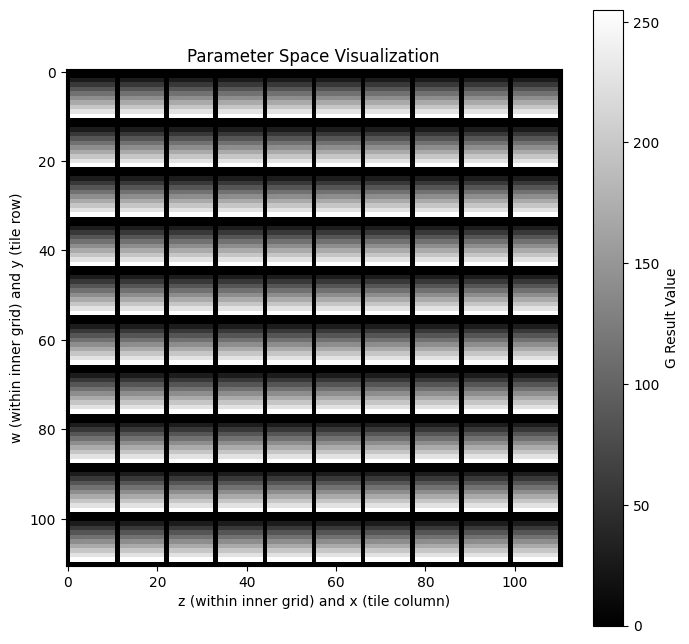

In [15]:
# --- Visualize Results ---
from PIL import Image
import matplotlib.pyplot as plt

padding_pixels = 1
inner_grid_width = num_variations_z
inner_grid_height = num_variations_w
tiled_grid_width = inner_grid_width + padding_pixels
tiled_grid_height = inner_grid_height + padding_pixels

total_img_width = tiled_grid_width * num_variations_x + padding_pixels
total_img_height = tiled_grid_height * num_variations_y + padding_pixels

image_output_cpu = np.empty((total_img_height, total_img_width), dtype=np.uint8)
image_output_gpu = drv.mem_alloc(image_output_cpu.nbytes)

min_result_G = np.min(results_G_cpu)
max_result_G = np.max(results_G_cpu)

block_size_viz = (16, 16, 1)
grid_size_viz = (
    (total_img_width + block_size_viz[0] - 1) // block_size_viz[0],
    (total_img_height + block_size_viz[1] - 1) // block_size_viz[1]
)

visualize_kernel(
    image_output_gpu,
    results_G_gpu,
    np.float32(min_result_G),
    np.float32(max_result_G),
    np.int32(num_variations_x),
    np.int32(num_variations_y),
    np.int32(num_variations_z),
    np.int32(num_variations_w),
    np.int32(padding_pixels),
    block=block_size_viz,
    grid=grid_size_viz
)

drv.memcpy_dtoh(image_output_cpu, image_output_gpu)

print("\n--- Visualization ---")
image = Image.fromarray(image_output_cpu, 'L')

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.title('Parameter Space Visualization')
plt.xlabel('z (within inner grid) and x (tile column)')
plt.ylabel('w (within inner grid) and y (tile row)')
plt.colorbar(label='G Result Value')
plt.show()

In [16]:

# --- Clean up GPU memory ---
results_F_gpu.free()
results_G_gpu.free()
image_output_gpu.free()

print("\nGPU memory freed.")


GPU memory freed.
